In [ ]:
!pip install yfinance numpy scipy matplotlib mplfinance plotly

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 5.6 MB/s eta 0:00:00


In [1]:
import yfinance as yf
import numpy as np
import scipy.stats as si
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import warnings
warnings.filterwarnings('ignore')

In [2]:
class black_scholes:
  def __init__(self, S, K, T, r, sigma):
    self.S = S   # asset price
    self.K = K   # strike price
    self.T = T   # time to expiration (years)
    self.r = r   # risk free interest
    self.sigma = sigma #volatility

  def f1(self):
    return (np.log(self.S / self.K) + (self.r + 0.5 * self.sigma ** 2) * self.T) / (self.sigma * np.sqrt(self.T))

  def f2(self):
    return self.f1() - self.sigma * np.sqrt(self.T)

  def call_price(self):
    return (self.S * si.norm.cdf(self.f1(), 0.0, 1.0) - self.K * np.exp(-self.r * self.T) * si.norm.cdf(self.f2(), 0.0, 1.0))

  def put_price(self):
    return (self.K * np.exp(-self.r * self.T) * si.norm.cdf(-self.f2(), 0.0, 1.0) - self.S * si.norm.cdf(-self.f1(), 0.0, 1.0))

  def vega(self):
    return self.S * si.norm.pdf(self.f1(), 0.0, 1.0) * np.sqrt(self.T)


In [3]:
def implied_volatility(market_price, S, K, T, r, option_type='call', initial_guess=0.3, max_iter=100, tolerance=1e-6):
  sigma = initial_guess
  for i in range(max_iter):
    bs = black_scholes(S, K, T, r, sigma)
    if option_type == 'call':
      price = bs.call_price()
    else:
      price = bs.put_price()

    diff = price - market_price
    if abs(diff) < tolerance:
      return sigma

    vega_val = bs.vega()
    sigma = sigma - diff / vega_val
    sigma = max(0.001, min(sigma, 5.0))
  return None

In [4]:
def options_data(ticker):
  ticker = yf.Ticker(ticker)
  dates = ticker.options
  data = ticker.option_chain(dates[0])
  return data.calls, data.puts

jpmc_calls, jpmc_puts = options_data('JPM')

In [5]:
ticker = yf.Ticker("JPM")
jpm_stock = ticker.history(period="1y")
jpm_stock.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2025-01-02 00:00:00-05:00,235.925676,238.236753,234.486148,235.024750,9220900,0.00,0.0
2025-01-03 00:00:00-05:00,238.834141,239.803624,235.279387,238.236786,9491100,0.00,0.0
2025-01-06 00:00:00-05:00,239.880596,241.839413,236.809499,237.075272,9917800,1.25,0.0
2025-01-07 00:00:00-05:00,238.345046,241.416143,237.124474,239.358902,8753400,0.00,0.0
2025-01-08 00:00:00-05:00,238.945485,240.421976,236.730748,239.319534,8675300,0.00,0.0


In [7]:
def calculate_historical_volatility(stock_data, window=252):
    log_returns = np.log(stock_data['Close'] / stock_data['Close'].shift(1))
    volatility = np.sqrt(window) * log_returns.std()
    return volatility

jpm_volatility = calculate_historical_volatility(jpm_stock)
print(f"JPM Historical Volatility: {jpm_volatility}")

JPM Historical Volatility: 0.25013894925261215


visualizing greeks:

In [8]:
class black_scholes_with_greeks(black_scholes):
    def delta_call(self):
        return si.norm.cdf(self.f1(), 0.0, 1.0)

    def delta_put(self):
        return -si.norm.cdf(-self.f1(), 0.0, 1.0)

    def gamma(self):
        return si.norm.pdf(self.f1(), 0.0, 1.0) / (self.S * self.sigma * np.sqrt(self.T))

    def theta_call(self):
        return (-self.S * si.norm.pdf(self.f1(), 0.0, 1.0) * self.sigma / (2 * np.sqrt(self.T)) - self.r * self.K * np.exp(-self.r * self.T) * si.norm.cdf(self.f2(), 0.0, 1.0))

    def theta_put(self):
        return (-self.S * si.norm.pdf(self.f1(), 0.0, 1.0) * self.sigma / (2 * np.sqrt(self.T)) + self.r * self.K * np.exp(-self.r * self.T) * si.norm.cdf(-self.f2(), 0.0, 1.0))

    def vega(self):
        return self.S * si.norm.pdf(self.f1(), 0.0, 1.0) * np.sqrt(self.T)

    def rho_call(self):
        return self.K * self.T * np.exp(-self.r * self.T) * si.norm.cdf(self.f2(), 0.0, 1.0)

    def rho_put(self):
        return -self.K * self.T * np.exp(-self.r * self.T) * si.norm.cdf(-self.f2(), 0.0, 1.0)


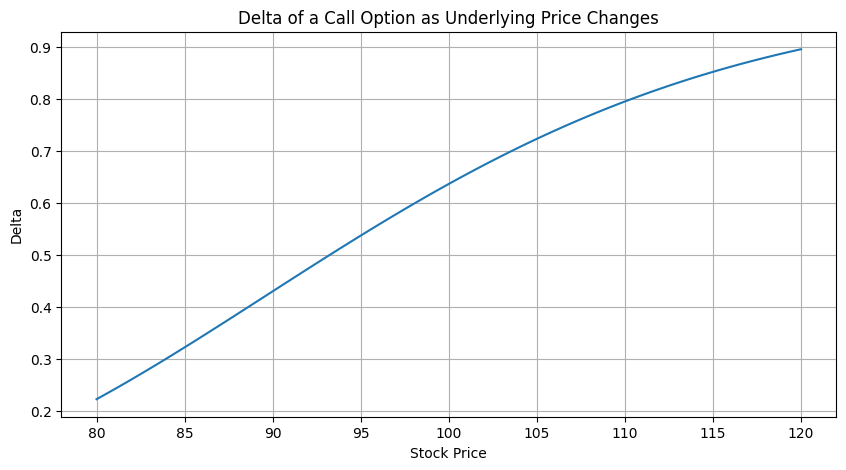

In [9]:
# rate of change of the option price with respect to changes in the underlying asset’s price
stock_prices = np.linspace(80, 120, 100)
deltas = [black_scholes_with_greeks(S=price, K=100, T=1, r=0.05, sigma=0.2).delta_call() for price in stock_prices]

plt.figure(figsize=(10, 5))
plt.plot(stock_prices, deltas)
plt.title('Delta of a Call Option as Underlying Price Changes')
plt.xlabel('Stock Price')
plt.ylabel('Delta')
plt.grid(True)

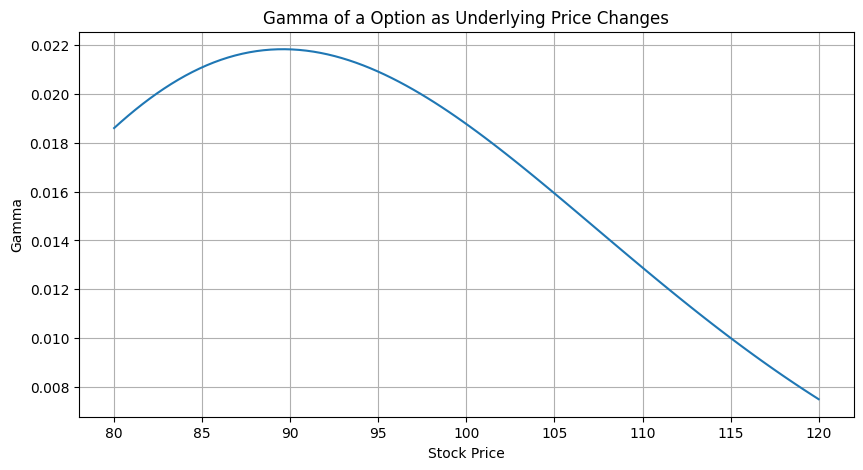

In [10]:
#rate of change in delta with respect to changes in the underlying asset’s price
stock_prices = np.linspace(80, 120, 100)
gamma = [black_scholes_with_greeks(S=price, K=100, T=1, r=0.05, sigma=0.2).gamma() for price in stock_prices]

plt.figure(figsize=(10, 5))
plt.plot(stock_prices, gamma)
plt.title('Gamma of a Option as Underlying Price Changes')
plt.xlabel('Stock Price')
plt.ylabel('Gamma')
plt.grid(True)

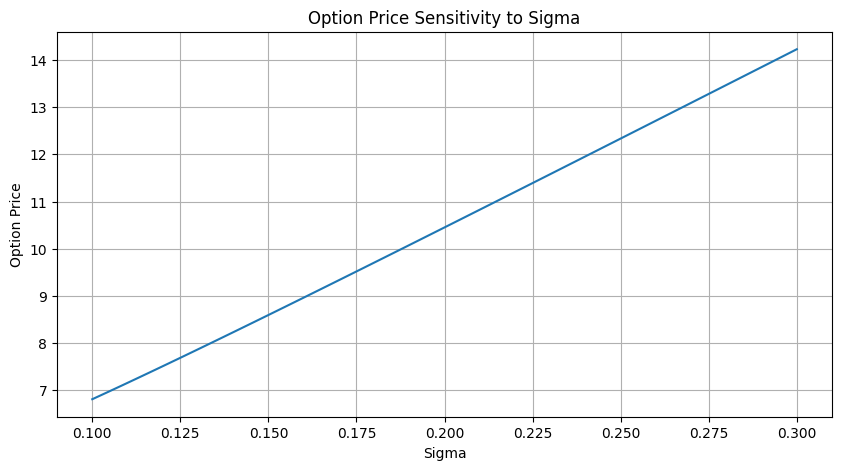

In [11]:
def plot_option_sensitivity(bs_model, parameter, values, option_type='call'):
    prices = []
    for value in values:
        setattr(bs_model, parameter, value)
        if option_type == 'call':
            prices.append(bs_model.call_price())
        else:
            prices.append(bs_model.put_price())

    plt.figure(figsize=(10, 5))
    plt.plot(values, prices)
    plt.title(f'Option Price Sensitivity to {parameter.capitalize()}')
    plt.xlabel(parameter.capitalize())
    plt.ylabel('Option Price')
    plt.grid(True)

bsm = black_scholes(S=100, K=100, T=1, r=0.05, sigma=0.2)
volatilities = np.linspace(0.1, 0.3, 100)
plot_option_sensitivity(bsm, 'sigma', volatilities, 'call')

In [12]:
S, K, T, r, sigma_true = 100, 100, 1.0, 0.05, 0.25
bs = black_scholes(S, K, T, r, sigma_true)
market_call_price = bs.call_price()
market_put_price = bs.put_price()

iv_call = implied_volatility(market_call_price, S, K, T, r, 'call')
iv_put = implied_volatility(market_put_price, S, K, T, r, 'put')

print(f"\nImplied Vol from Call: {iv_call:.2%}")
print(f"Implied Vol from Put: {iv_put:.2%}")
print(f"Error: {abs(iv_call - sigma_true):.4%}")


Implied Vol from Call: 25.00%
Implied Vol from Put: 25.00%
Error: 0.0000%
